# **Save this file as studentid1_studentid2_lab2.ipynb**, please check this suffix when you upload your lab, especially when you have multiple copy's in the same folder!
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "IOANNIS GATOPOULOS"
NAME2 = "NITHIN KATKERE HOLLA"
EMAIL = "ioannis.gatopoulos@student.uva.nl"
EMAIL2 = "nithin.holla@student.uva.nl"

# Lab 2: Classification

### Machine Learning 1, November 2018

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

/Users/johngatopoulos/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/johngatopoulos/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

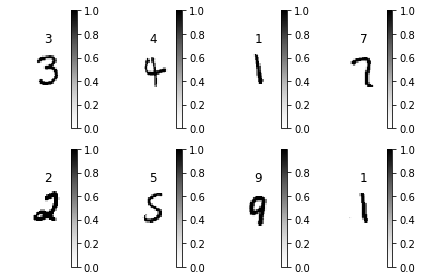

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



YOUR ANSWER HERE

For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{q_j}{Z}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= - \frac{q_j}{Z}
\end{align}
since $\frac{\partial \log Z}{\partial Z} = \frac{1}{Z}$ and $\frac{\partial Z}{\partial \log q_j} = \frac{\partial}{\partial \log q_j} \sum_k q_k = \frac{\partial}{\partial \log q_j} \sum_k e^{\log q_k} = q_j$

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

YOUR ANSWER HERE
\begin{align}
    \frac{\partial \log q_j}{\partial W_{ij}} &= \frac{\partial}{\partial W_{ij}} (\bw_j^T \bx + b_j) = x_i \\
    \therefore \frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} &=
    \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} 
    \frac{\partial \log q_j}{\partial W_{ij}} = \mathbf{\delta}_j^qx_i
\end{align}    
In vector form, the gradient is
\begin{align}
    \nabla_{\bw_j} \mathcal{L}^{(n)} &= \begin{bmatrix}
    \mathbf{\delta}_j^qx_1 & \mathbf{\delta}_j^qx_2 & ... & \mathbf{\delta}_j^qx_D
    \end{bmatrix} = \mathbf{\delta}_j^q \bx^T
\end{align}

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
def log_sum_exp(x):
    a = np.max(x)
    sum_exp = np.exp(x - a).sum()
    return a + np.log(sum_exp)


# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    
    logq = (np.dot(x, w) + b).squeeze()
    q = np.exp(logq)
    
    Z = np.sum(q)
    max_q = np.max(logq)
    logZ = log_sum_exp(logq)
    
    logp = logq - logZ
    logp = np.expand_dims(logp, axis = 0)
    
    # Gradient computation
    one_hot = np.zeros(w.shape[1])
    one_hot[t] = 1
    
    delta = one_hot - q / Z
    dL_dw = np.outer(x, delta)
    dL_db = delta
    
    # here the statement contains logp[:,t] where logp is meant tas a matrix of shape 1x10
    
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()

In [7]:
# Hidden tests for efficiency

In [8]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [9]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.361294698287258e-07
Finite difference error grad_b: 5.235117496167733e-08


In [10]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [11]:
def sgd_iter(x_train, t_train, W, b):
    
    # YOUR CODE HERE
    lr = 1e-4
    logp_train = 0
    for i in range(len(t_train)):
        logp, grad_w, grad_b = logreg_gradient(x_train[i,:], t_train[i], W, b)
        logp_train += logp
        W = W + lr * grad_w
        b = b + lr * grad_b
    return logp_train, W, b

In [12]:
# Hidden tests for efficiency

In [13]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

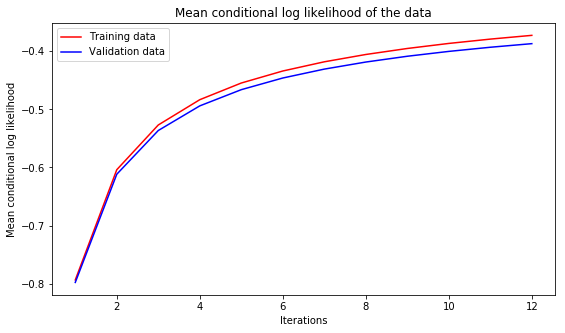

In [14]:
def evaluate_likelihood(X, T, w, b):
    logq = np.dot(X, w) + b
    max_logq = logq.max(axis=1)
    diff = logq - max_logq[:, None]
    logZ = max_logq + np.log((np.exp(diff)).sum(axis=1))

    # Log likelihood matrix
    logp = logq - logZ[:, None]

    # Likelihood vector
    likelihood_vec = logp[np.arange(X.shape[0]), T]
    mean_likelihood = np.mean(likelihood_vec)
    
    return likelihood_vec, mean_likelihood
    

def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    # YOUR CODE HERE
    epsilon = 0.013 # 12 iterations
    i = 0
    train_likelihood_iter = []
    valid_likelihood_iter = []
    while True:
        i += 1
        w_old = np.array(w)
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)
        train_likelihood_iter.append(evaluate_likelihood(x_train, t_train, w, b)[1])
        valid_likelihood_iter.append(evaluate_likelihood(x_valid, t_valid, w, b)[1])
        if np.all(abs(w - w_old) < epsilon):
            break
    return w, b, train_likelihood_iter, valid_likelihood_iter
    
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w, b, train_likelihood_iter, valid_likelihood_iter = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

# Figure size
plt.rcParams["figure.figsize"] = [9,5]

# Plot log likelihood
plt.plot(range(1, len(train_likelihood_iter) + 1), train_likelihood_iter, 'r', label = 'Training data')
plt.plot(range(1, len(valid_likelihood_iter) + 1), valid_likelihood_iter, 'b', label = 'Validation data')
plt.xlabel('Iterations')
plt.ylabel('Mean conditional log likelihood')
plt.title('Mean conditional log likelihood of the data')
plt.legend();

In [15]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


Visualization of weights:


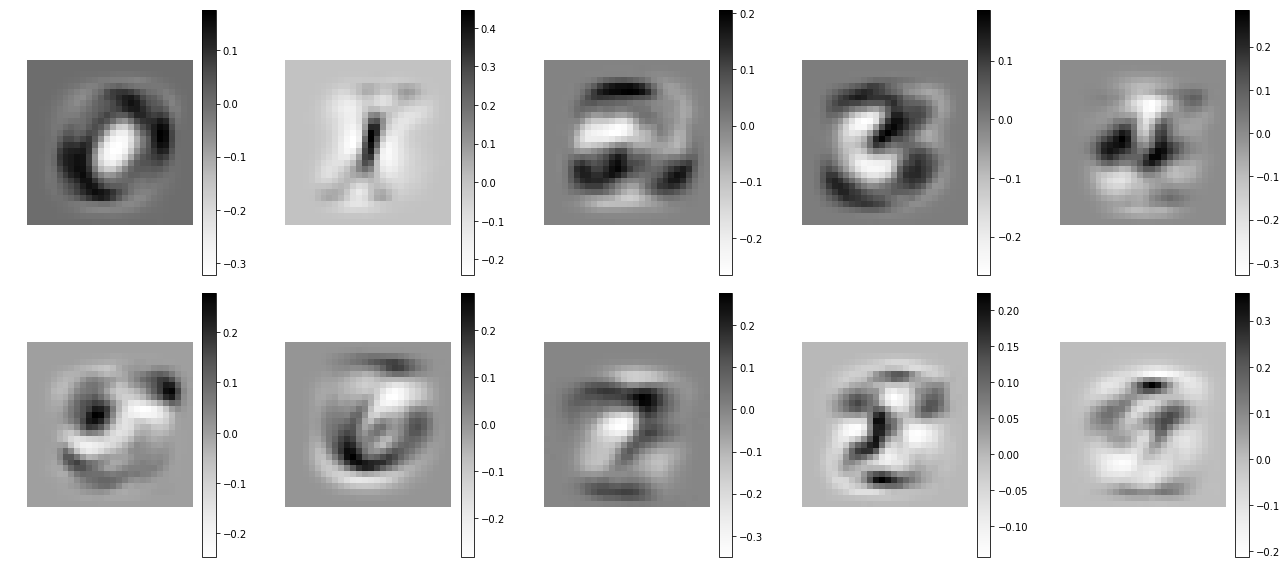

In [16]:
# YOUR CODE HERE
plt.rcParams["figure.figsize"] = [18,8]
print("Visualization of weights:")
plot_digits(w.T, num_cols = 5)

**Describe in less than 100 words why these weights minimize the loss**

An image is assigned to a class if the activation at the corresponding output neuron is high. Activation is high if the weights are similar to the representative image of the digit. For example, for digit 0, black weights which are higher, form a circle and the white weights which are lower leave a hole. The product of this is high for a zero digit because it overlaps. Generally, the weights represent an average of all possible shapes of a digit and that is why they have this dreamy shape. 

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


Easiest digits:


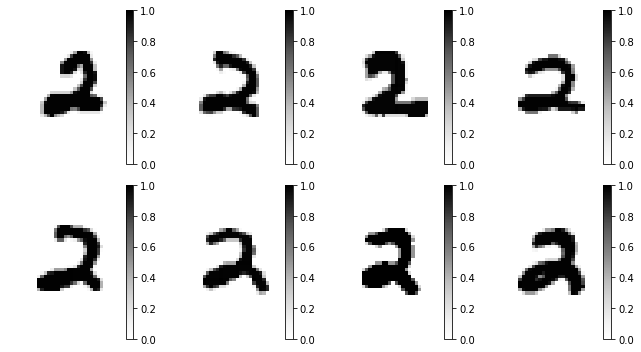

Hardest digits:


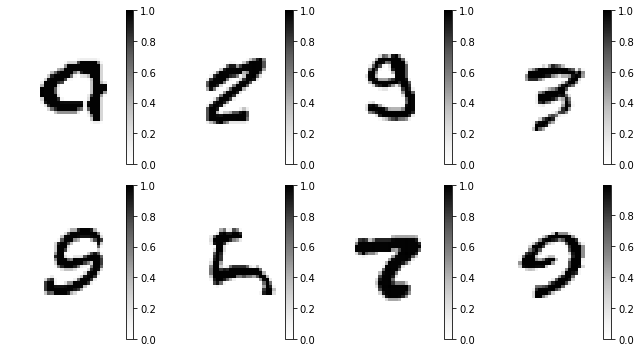

In [17]:
# YOUR CODE HERE
plt.rcParams["figure.figsize"] = [9,5]
valid_likelihood_vec = evaluate_likelihood(x_valid, t_valid, w, b)[0]
sorted_image_indices = np.argsort(valid_likelihood_vec)

highest_prob_images = sorted_image_indices[-8:]
lowest_prob_images = sorted_image_indices[:8]

print("Easiest digits:")
plot_digits(x_valid[highest_prob_images], num_cols = 4)

print("Hardest digits:")
plot_digits(x_valid[lowest_prob_images], num_cols = 4)

Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

The results do make sence, since the shape of digit 2 is far more different form the others; its form has unique features that are hard to find in the others, hence the algorithm can distinguish it easily. However, in the set of the __hard digits__, some of the misclassifications are justified, because the images are very hard to determine with certainty, even for humans, due to bad handwritting. Furthermore, in the hard class, we will find digits that are only different from others by small feature (for example a small curve is the only thing that seperates the 9 from the 8) which, even though it is quite obvious and should have been classified correctly, our model fails due to its simplicity.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

YOUR ANSWER HERE

The output layer here computes a softmax over its inputs which is identical to the output operation in multiclass logistic regression earlier. Therefore, $\nabla_{\bb} \mathcal{L}^{(n)}$ is same as before whereas $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is similar, with $\bh^T$ replacing $\bx^T$ since the input to the softmax layer is $\bh$.
\begin{align} 
    \nabla_{\bb} \mathcal{L}^{(n)} &= \mathbf{\delta}_j^q \\
    \nabla_{\bw_j} \mathcal{L}^{(n)} &= \mathbf{\delta}_j^q \bh^T \\
    \implies \nabla_{\bW} \mathcal{L}^{(n)} &= \bh \mathbf{\delta}^q 
\end{align}
where
\begin{align}
    \delta^q_j 
     &= \begin{cases}
        1 - \frac{q_j}{Z}, & \text{for} \; j = t^{(n)} \\
       - \frac{q_j}{Z}, & \text{for} \; j \neq t^{(n)}
    \end{cases}
\end{align}

Now,
\begin{align}
    \mathbf{\delta}_j^h &= \frac{\partial \mathcal{L}^{(n)}}{\partial h_j} \\
    &= \sum_{k=1}^K \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_k} \frac{\partial \log q_k}{\partial h_k} \\
    &= \sum_{k=1}^K \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_k} \frac{\partial}{\partial h_k} (\bw_j^T \bh + b_k) \\
    &= \sum_{k=1}^K \delta_{k}^q W_{jk}
\end{align}

The gradient with respect to $\bV$ and $\ba$ can be computed as follows:
\begin{align}
    \frac{\partial \mathcal{L}^{(n)}}{\partial V_{ij}} &= \frac{\partial \mathcal{L}^{(n)}}{\partial h_j} \frac{\partial h_j}{\partial V_{ij}} \\
    &= \mathbf{\delta}_j^h \frac{\partial}{\partial V_{ij}} \sigma(\bv_j^T \bx + a_j) \\
    &= \mathbf{\delta}_j^h \sigma(\bv_j^T \bx + a_j) (1 -\sigma(\bv_j^T \bx + a_j)) \frac{\partial}{\partial V_{ij}} (\bv_j^T \bx + a_j) \\
    &= \mathbf{\delta}_j^h h_j (1 - h_j) x_i
\end{align}    
Similarly,
\begin{align}
    \frac{\partial \mathcal{L}^{(n)}}{\partial a_j} &= \mathbf{\delta}_j^h h_j (1 - h_j) \frac{\partial}{\partial a_j} (\bv_j^T \bx + a_j) \\
    &= \mathbf{\delta}_j^h h_j (1 - h_j)
\end{align}    
So, in vector form,
\begin{align} 
\nabla_{\bv_j} \mathcal{L}^{(n)} &= \mathbf{\delta}_j^h h_j (1-h_j) \bx^T \\ 
\implies \nabla_{\bV} \mathcal{L}^{(n)} &= \bx (\mathbf{\delta}^h \cdot h \cdot (1-h)) \\ 
\nabla_{\ba} \mathcal{L}^{(n)} &= \mathbf{\delta}^h \cdot h \cdot (1-h) 
\end{align}
where $\cdot$ denotes element-wise multiplication.



## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

YOUR ANSWER HERE


Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

\begin{align*} \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)} \end{align*}

where

\begin{align*} \mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)} \\ \\ \end{align*}



Since the prior is a Gaussian on the parameters, we can write

\begin{align*}
      \boldsymbol{W}, \boldsymbol{V}, \boldsymbol{a} , \boldsymbol{b} \sim \mathcal{N}
\end{align*}

Lets denote $\theta$ as
\begin{align*}
      \theta = ( \boldsymbol{W}, \boldsymbol{V}, \boldsymbol{a} , \boldsymbol{b} )
\end{align*}


From Bayes' Law we would have:

\begin{align*}
      p ( \boldsymbol{\theta} | t^{(n)}, \bx^{(n)}) = \frac{ p(t^{(n)} | \boldsymbol{\theta}, \bx^{(n)}) \hspace{2pt} p( \boldsymbol{\theta})} {  p(t^{(n)}| \bx^{(n)}) } 
\end{align*}

The MAP estimate of $\theta$ is given by

\begin{align*}
     \boldsymbol{\theta}^{MAP} = argmax_{\theta}  p ( \boldsymbol{\theta} | t^{(n)}, \bx^{(n)})
     = argmax_{\theta} p(t^{(n)} | \boldsymbol{\theta}, \bx^{(n)}) \hspace{2pt} p( \boldsymbol{\theta})
\end{align*}

since the evidence does not depend on $\theta$. Hence

\begin{align*}
     \boldsymbol{\theta}^{MAP} &= argmax_{\theta}  \log p ( \boldsymbol{\theta} | t^{(n)}, \bx^{(n)})
     \\&= argmax_{\theta} \Big( \log p(t^{(n)} | \boldsymbol{\theta}, \bx^{(n)}) + \log p( \boldsymbol{\theta}) \Big) \\
     &= argmax_{\theta} \Big( \mathcal{L}^{(n)} + \log p( \boldsymbol{\theta}) \Big)  \\
\end{align*}

Now since the priors of the parameters are indepentent, we will have

\begin{align*}
     \log p( \boldsymbol{\theta}) &= \log p( \boldsymbol{W}, \boldsymbol{V}, \boldsymbol{a} , \boldsymbol{b} ) \\
     &= \log \Big( p( \boldsymbol{W}) p( \boldsymbol{V}) p(\boldsymbol{a}) p( \boldsymbol{b} ) \Big) \\
     &= \log p( \boldsymbol{W}) + \log p( \boldsymbol{V}) + \log p(\boldsymbol{a}) + \log p(\boldsymbol{b} ) \\
\end{align*}

Finally, our MAP solution will be

\begin{align*}
     \theta_{MAP} = argmax_{\theta}  \log p ( \boldsymbol{\theta} | t^{(n)}, \bx^{(n)})
     &= argmax_{\theta} \Big( \mathcal{L}^{(n)} + \log p( \boldsymbol{W}) + \log p( \boldsymbol{V}) + \log p(\boldsymbol{a}) + \log p(\boldsymbol{b} )  \Big)  \\
\end{align*}


## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [18]:
# Write all helper functions here
# YOUR CODE HERE

class NeuralNetwork():

    def __init__(self, input_size=28 * 28, hidden_units=20, activation_function='sigmoid', output_units=10):
        self.input_size = input_size  # Number of units in the input layer
        self.L = hidden_units  # Number of units in the hidden layer
        self.output_size = output_units  # Number of units in the output layer
        self.V = np.random.normal(loc=0, scale=np.sqrt(2 / input_size), size=(input_size, self.L))  # Weights from input to hidden layer
        self.W = np.random.normal(loc=0, scale=np.sqrt(2 / hidden_units), size=(self.L, output_units))  # Weights from hidden to input layer
        self.a = np.zeros(self.L)  # Bias from input to hidden layer
        self.b = np.zeros(self.output_size)  # Bias from hidden to input layer
        self.activation_function = activation_function  # Activation function for the hidden layer
        self.weights_capture = None # Stores intermediate weights V during training

    def hidden_layer_output(self, x):
        h_input = np.dot(x, self.V) + self.a
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-h_input))

    def activation_func_deriv(self, h_output):
        if self.activation_function == 'sigmoid':
            return h_output * (1 - h_output)

    def forward_propagation(self, x):
        # Hidden layer computations
        h_output = self.hidden_layer_output(x)

        # Output layer computations
        logq = np.dot(h_output, self.W) + self.b
        q = np.exp(logq)
        logZ = log_sum_exp(logq)
        Z = np.exp(logZ)

        # Log likelihood
        logp = logq - logZ

        return h_output, q, Z, logp

    def back_propagation(self, x, t, h_output, q, Z, learn_rate):
        # Obtain one hot encoding of the target
        one_hot_vector = np.zeros(self.output_size)
        one_hot_vector[t] = 1

        # Gradient at the output layer
        delta_q = one_hot_vector - q / Z

        # Gradient at the hidden layer
        delta_h = np.dot(delta_q, self.W.T)

        # Compute gradients
        dL_dW = np.dot(h_output[:, None], delta_q[None, :])
        dL_db = delta_q
        h_deriv = self.activation_func_deriv(h_output)
        dL_dV = delta_h * h_deriv * x[:, None]
        dL_da = delta_h * h_deriv

        # Update weights
        self.V += learn_rate * dL_dV
        self.b += learn_rate * dL_db
        self.W += learn_rate * dL_dW
        self.a += learn_rate * dL_da

    def evaluate(self, X, T):
        # Hidden layer output
        h_output = self.hidden_layer_output(X)

        # Output layer
        logq = np.dot(h_output, self.W) + self.b
        max_logq = logq.max(axis=1)
        diff = logq - max_logq[:, None]
        logZ = max_logq + np.log((np.exp(diff)).sum(axis=1))

        # Log likelihood matrix
        logp = logq - logZ[:, None]

        # Likelihood vector
        likelihood = logp[np.arange(X.shape[0]), T]

        return np.mean(likelihood)

    def train(self, x_train, t_train, x_valid, t_valid, epochs, learn_rate, verbose=True, capture_epochs=None):
        train_likelihood = np.zeros(epochs)
        validation_likelihood = np.zeros(epochs)
        if capture_epochs is not None:
            self.weights_capture = np.ndarray((len(capture_epochs) + 1, self.V.shape[0], self.V.shape[1]))
            self.weights_capture[0] = np.array(self.V)
        for e in range(epochs):
            for x, t in zip(x_train, t_train):
                h_output, q, Z, logp = self.forward_propagation(x)
                self.back_propagation(x, t, h_output, q, Z, learn_rate)
            train_likelihood[e] = self.evaluate(x_train, t_train)
            validation_likelihood[e] = self.evaluate(x_valid, t_valid)
            if capture_epochs is not None and e in capture_epochs:
                index = capture_epochs.index(e) + 1
                self.weights_capture[index] = np.array(self.V)
            if verbose:
                print("Epoch %d:" % e)
                print("Training likelihood = %.10f" % train_likelihood[e])
                print("Validation likelihood = %.10f" % validation_likelihood[e])
        return train_likelihood, validation_likelihood

In [19]:
# Hidden tests for efficiency

In [20]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.

# 

# YOUR CODE HERE

np.random.seed(1234)
nn1 = NeuralNetwork(input_size=28 * 28, hidden_units=20, activation_function='sigmoid', output_units=10)
train_likelihood1, validation_likelihood1 = nn1.train(x_train, t_train, x_valid, t_valid, epochs=10, learn_rate=1e-2, verbose=False, capture_epochs=[4, 9])

np.random.seed(1234)
nn2 = NeuralNetwork(input_size=28 * 28, hidden_units=20, activation_function='sigmoid', output_units=10)
train_likelihood2, validation_likelihood2 = nn2.train(x_train, t_train, x_valid, t_valid, epochs=10, learn_rate=1e-3, verbose=False, capture_epochs=[4, 9])

np.random.seed(1234)
nn3 = NeuralNetwork(input_size=28 * 28, hidden_units=20, activation_function='sigmoid', output_units=10)
train_likelihood3, validation_likelihood3 = nn3.train(x_train, t_train, x_valid, t_valid, epochs=10, learn_rate=1e-4, verbose=False, capture_epochs=[4, 9])

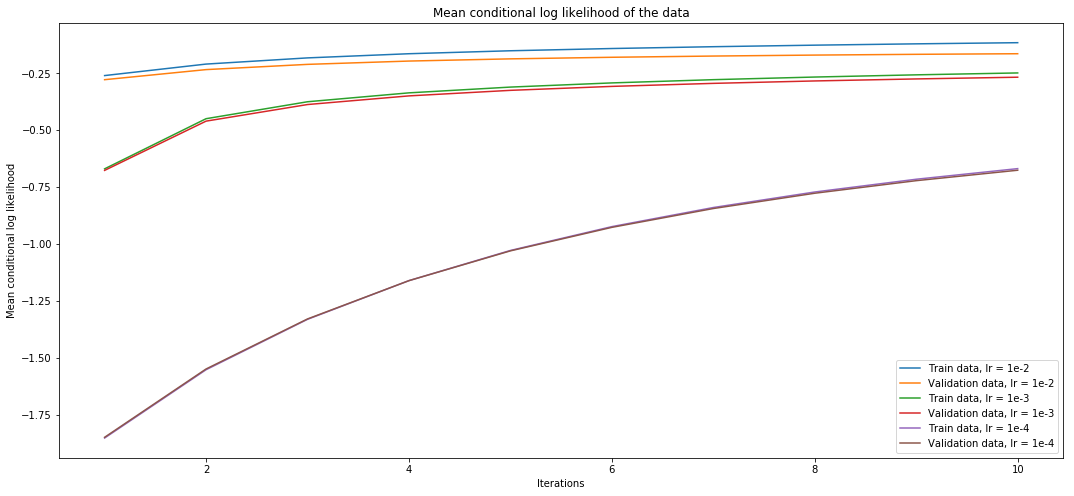

In [21]:
# plot the train and validation logp for all three learning rates in one figure

plt.rcParams["figure.figsize"] = [18,8]


# YOUR CODE HERE
plt.figure()
plt.plot(range(1, 11), train_likelihood1, label='Train data, lr = 1e-2')
plt.plot(range(1, 11), validation_likelihood1, label='Validation data, lr = 1e-2')
plt.plot(range(1, 11), train_likelihood2, label='Train data, lr = 1e-3')
plt.plot(range(1, 11), validation_likelihood2, label='Validation data, lr = 1e-3')
plt.plot(range(1, 11), train_likelihood3, label='Train data, lr = 1e-4')
plt.plot(range(1, 11), validation_likelihood3, label='Validation data, lr = 1e-4')
plt.xlabel('Iterations')
plt.ylabel('Mean conditional log likelihood')
plt.title('Mean conditional log likelihood of the data')
plt.legend();

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

YOUR ANSWER HERE

All three learning rates result in training and validation likelihood curves that increase with every iteration, indicating that the models are not overfitting. Given a fixed number of epochs (10), a learning rate of 1e-2 gives the best performance at termination. However, the improvement over the epochs is lower since the first epoch took a significantly larger step that got it close to the optima. Given sufficient number of epochs, learning rate 1e-4 is likely to reach the optima. 

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

Best model has learning rate =  0.01
Weights of the hidden layer at epoch 0:


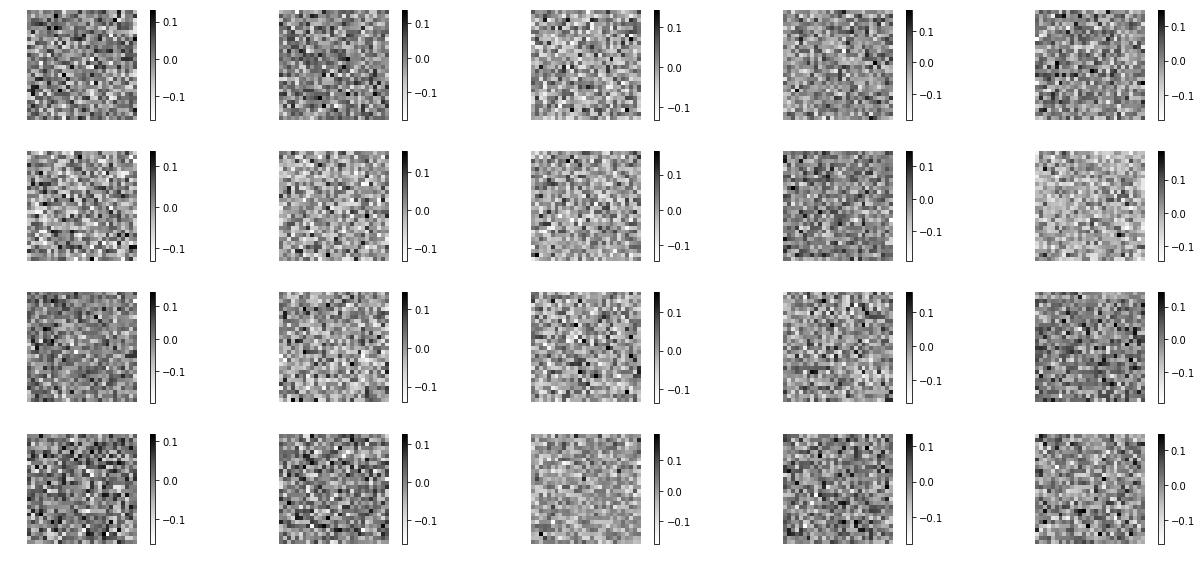

Weights of the hidden layer at epoch 4:


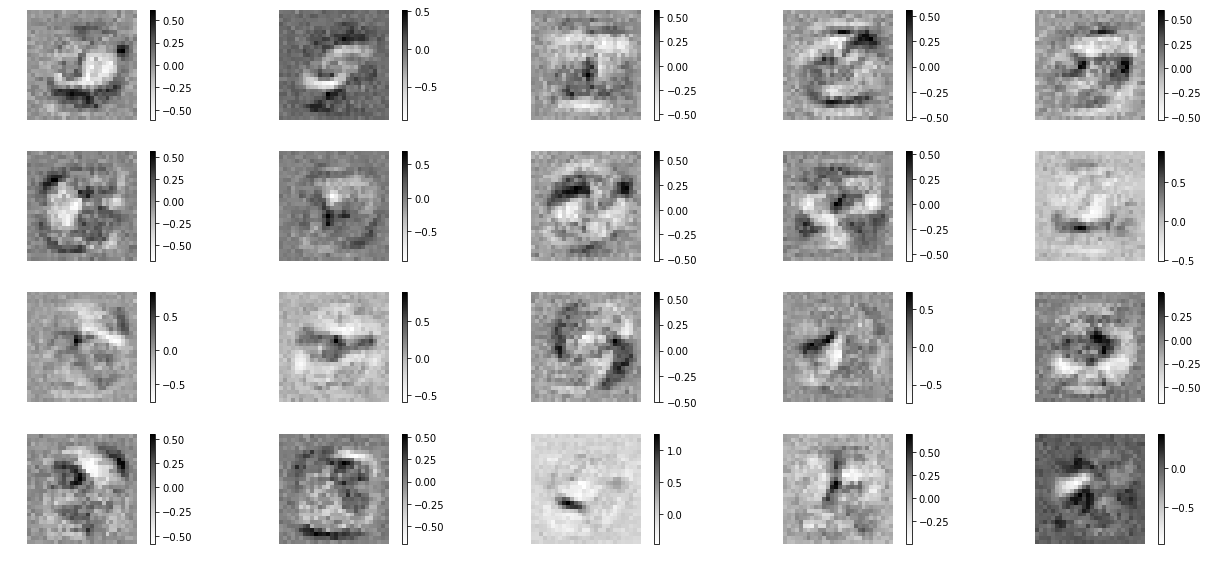

Weights of the hidden layer at epoch 9:


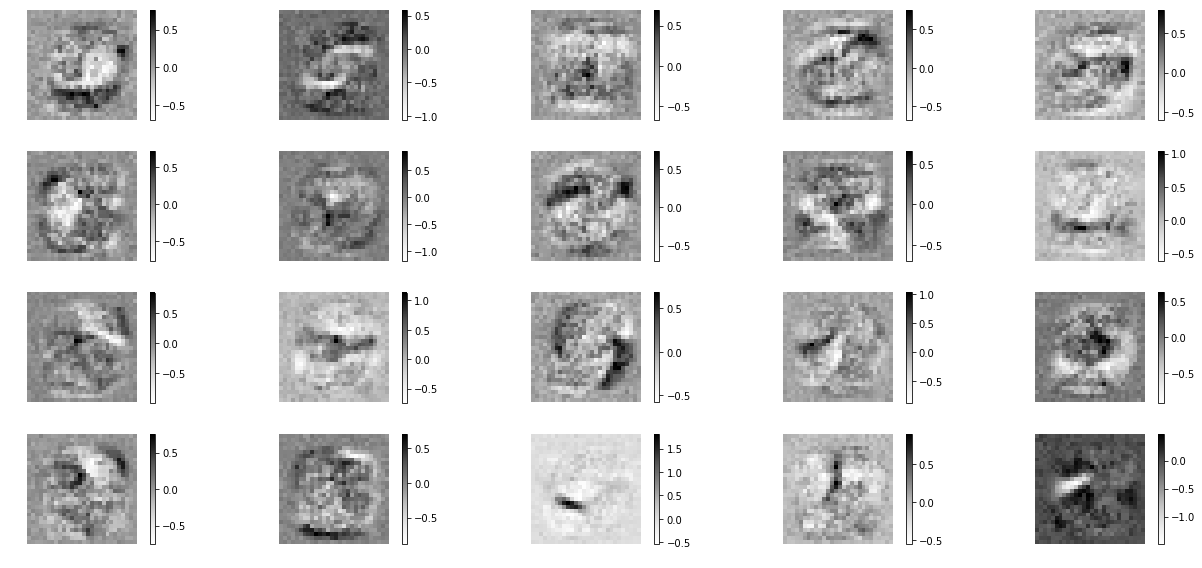

In [22]:
# Plot the weights of the first layer for the best model 
plt.rcParams["figure.figsize"] = [18,8]


# YOUR CODE HERE
best_model = np.argmax([validation_likelihood1[-1], validation_likelihood2[-1], validation_likelihood3[-1]])

learning_rates = [1e-2, 1e-3, 1e-4]
print("Best model has learning rate = ", learning_rates[best_model])
capture_epochs = [0, 4, 9]

for i, e in enumerate(capture_epochs):
    print("Weights of the hidden layer at epoch %d:" % e)
    if best_model == 0:
        plot_digits(nn1.weights_capture[i].T, num_cols=5)
    if best_model == 1:
        plot_digits(nn2.weights_capture[i].T, num_cols=5)
    if best_model == 2:
        plot_digits(nn3.weights_capture[i].T, num_cols=5)

YOUR ANSWER HERE

Each unit in the hiddden layer feeds to each unit in the output layer, due to which the weights are not 'ghost digits' like in logistic regression. The weights of the hidden layer transform the input image to features which have a richer but an abstract representation to the human eye. These learned features are such that they aid in a more accurate classification of the digits at the output layer.

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

YOUR ANSWER HERE

The ReLU activation function can be written as

$$\begin{align*}
    f(x) = max(0,x) &= \begin{cases}
    x & \text{, if } x \geq 0 \\
    0 & \text{, otherwise}
\end{cases}
\end{align*}$$

So,

If $x>0$, then $\frac{\partial}{\partial x} f(x) = \frac{\partial }{\partial x} x = 1$
    
If $x<0$, then $\frac{\partial  }{\partial x}f(x) = \frac{\partial }{\partial x} 0 = 0$
    
If $x=0$:
    $$\begin{align*}
        \lim_{x \to 0} \frac{f(x) - f(0)}{x - 0} = 
        \lim_{x \to 0} \frac{f(x)}{x }
        &= \begin{cases}
            \lim_{x \to 0^{+} } \frac{f(x)}{x } =
            \lim_{x \to 0^{+} } \frac{x}{x} =1
            \\
            \\
             \lim_{x \to 0^{-} } \frac{f(x)}{x } =
            \lim_{x \to 0^{-} } \frac{0}{x} =0
        \end{cases}
      \end{align*}$$
      
Since $ lim_{x \to 0^{+} } \frac{f(x) - f(0)}{x - 0} \neq \lim_{x \to 0^{-} } \frac{f(x) - f(0)}{x - 0} $, $ReLU(x)$ has an undefined derivate at x=0.
\begin{align*}
    f'(x) &= \begin{cases}
    1 & \text{, if } x > 0 \\
    0 & \text{, if } x < 0 \\
    \text{undefined} & \text{, if } x = 0  
\end{cases}
\end{align*}


The derivative of $tanh$ function would be

$$\begin{align*} 
\frac{\partial}{\partial x} tanh(x) &= \frac{\partial}{\partial x} \Big( \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}} \Big) \\
&= \frac{(e^{x}+e^{-x})(e^{x}+e^{-x}) - (e^{x}-e^{-x})(e^{x}-e^{-x}) }{(e^{x}+e^{-x})^2} \quad \text{(by quotient rule)} \\
&= 1 -  \frac{(e^{x}-e^{-x})^2 }{(e^{x}+e^{-x})^2}\\
&= 1 - tanh^2(x)
\end{align*}$$

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

YOUR ANSWER HERE

Two important properties are <b>non-linearity</b> and the <b>continuous differentiability</b>. The former because these kind of activation functions allow such networks to compute non-trivial problems using only a small number of nodes, and the latter because it will allow as to enable gradient-based optimization methods.

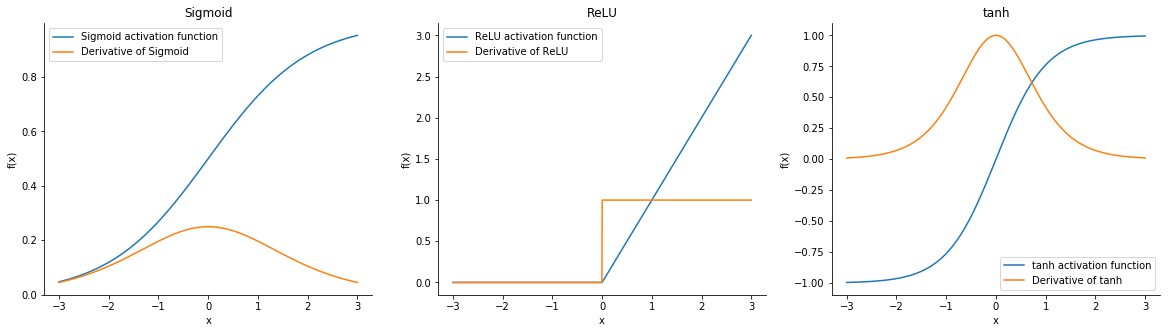

In [23]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.
plt.rcParams["figure.figsize"] = [9,5]


# YOUR CODE HERE
def sigmoid(x, prime):
    if prime == False:
        return 1 / (1 + np.exp(-x))
    elif prime == True:
        return sigmoid(x, False) * (1 - sigmoid(x, False))

def relu(x, prime):
    if prime == False:
        return np.maximum(0, x)
    elif prime == True:
        x_prime = np.array(x)
        x_prime[x > 0] = 1
        x_prime[x < 0] = 0
        x_prime[x == 0] = np.nan
        return x_prime
    
def tanh(x, prime):
    if prime == False:
        return (1 - np.exp(-2*x)) / (1 + np.exp(-2*x))
    elif prime == True:
        return 1 - tanh(x, False)**2
    
x = np.linspace(-3, 3, 1000)
y = np.linspace(-3, 3, 1000)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

funcs = ['Sigmoid', 'ReLU', 'tanh']

for i in range(len(funcs)):
    if funcs[i] == 'Sigmoid':
        f = sigmoid(x, False)
        f_prime = sigmoid(x, True)
    elif funcs[i] == 'ReLU':
        f = relu(x, False)
        f_prime = relu(x, True)
    elif funcs[i] == 'tanh':
        f = tanh(x, False)
        f_prime = tanh(x, True)
    axes[i].plot(x, f, label="%s activation function" % funcs[i])
    axes[i].plot(x, f_prime, label="Derivative of %s" % funcs[i])
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('f(x)')
    axes[i].set_title(funcs[i])
    axes[i].spines['right'].set_color('none')
    axes[i].spines['top'].set_color('none')
    axes[i].legend();

Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

YOUR ANSWER HERE

ReLU activation function for the hidden layer is more preferable over sigmoid and tanh in deep networks because they both suffer from the vanishing gradient problem; the gradient will be vanishingly small, effectively preventing the weight from changing its value and stop the neural network from further training. For the sigmoid, the maximum derivative is 0.25, so the errors in the output layer get reduced by at least 75\%, and errors in the hidden layer are scaled down by at least 93.75\%! For the tanh, if the activation is high, the gradient will be zero making backpropagation produce zero gradients.

In [24]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))

Notebook ran in 3.83 minutes.
